In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import COBYLA

from qiskit import *
import qiskit.quantum_info as qi
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import *
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pi = math.pi

## Biased Pauli Noise
Here we will be considering Biased Pauli


In [2]:
noise_model = NoiseModel()

p_err = 0.02
b_err = 0.0010
error_1q = pauli_error([('I',1-p_err-b_err),('X',p_err/3),('Y',p_err/3),('Z',p_err/3+b_err)]) # 1 qubit Biased Pauli error
noise_model.add_all_qubit_quantum_error(error_1q, ['delay']) 

backend = AerSimulator(noise_model=noise_model)

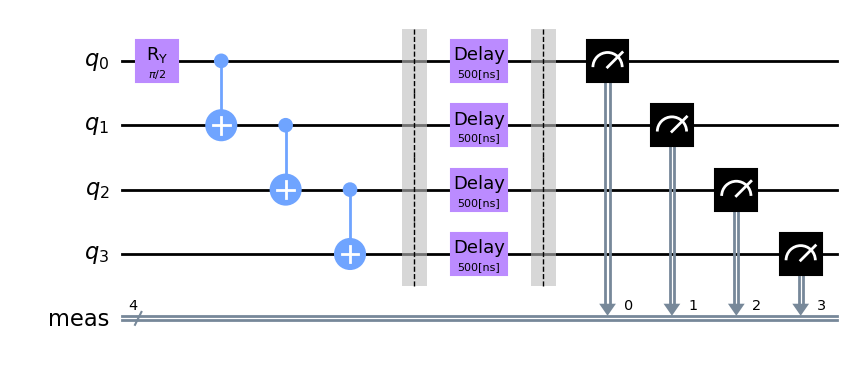

In [3]:
def U_prep(n_qubits,theta):
  qc = QuantumCircuit(n_qubits)
  qc.ry(theta,0)
  for qubit in range(n_qubits-1):
    qc.cx(qubit,qubit+1)
  qc.barrier()
  return qc

qc_without_hadamard = U_prep(4,pi/2)
qc_without_hadamard.delay(500,unit='ns')
qc_without_hadamard.measure_all()
qc_without_hadamard.draw('mpl')

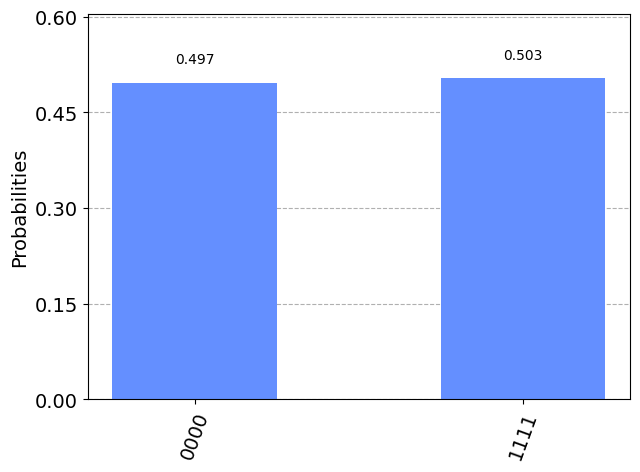

In [4]:
#Backend without Noise
results_ideal = AerSimulator().run(qc_without_hadamard,shots=10000).result()
counts_ideal = results_ideal.get_counts()
plot_histogram(counts_ideal)


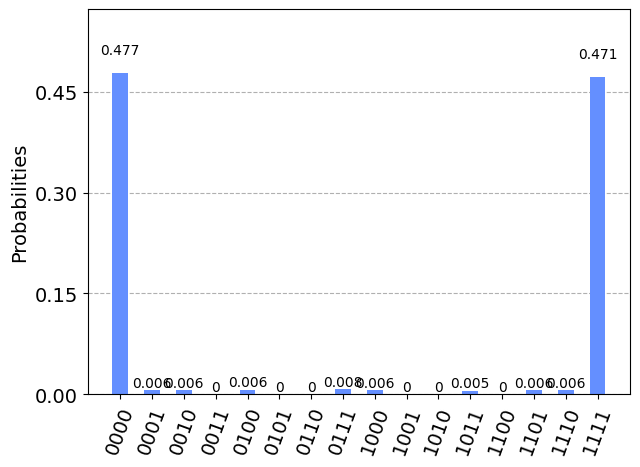

In [5]:
#Backend with noise
counts_without_hadamard = backend.run(qc_without_hadamard,shots=10000).result().get_counts()
plot_histogram(counts_without_hadamard)

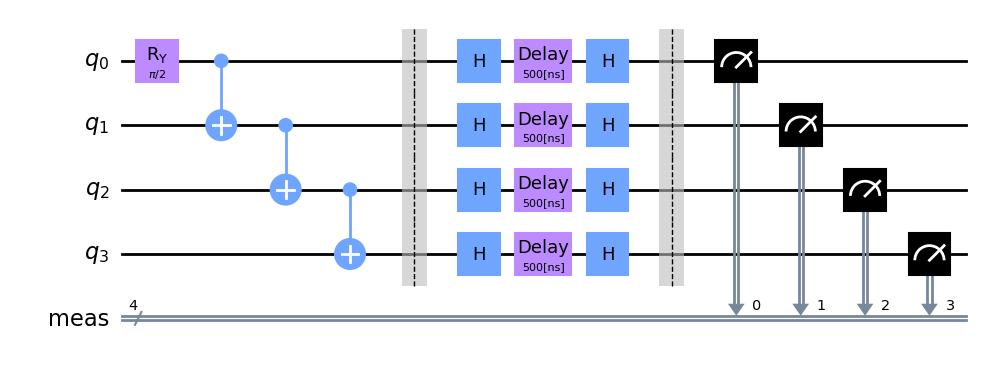

In [6]:
def padded_circuit(n_qubits,theta,delay):
  qc = U_prep(n_qubits,theta)

  for qubit in range(n_qubits):
    qc.h(qubit)
    qc.delay(delay,qubit,unit='ns')
    qc.h(qubit)
  qc.measure_all()
  return qc

qc_with_hadamard = padded_circuit(4,pi/2, 500)
qc_with_hadamard.draw('mpl')


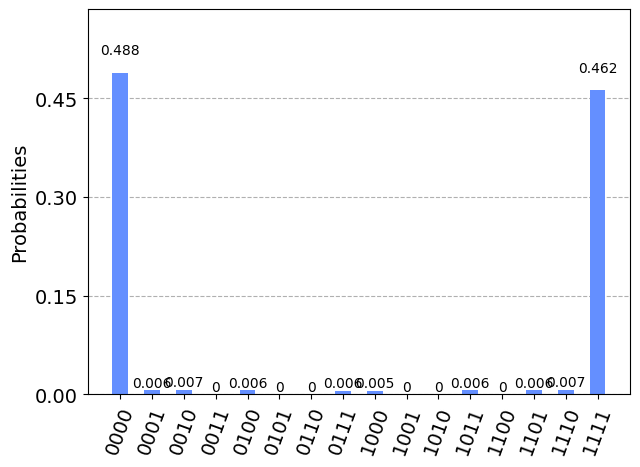

In [7]:
#Backend with Noise and padding both sides with the Hadamard gate
counts_with_hadamard = backend.run(qc_with_hadamard,shots=10000).result().get_counts()
plot_histogram(counts_with_hadamard)

In [8]:
# If state is not in the set of valid states, ouput is erroneous
def cost(counts):
  invalid_states_count = 0
  diff = 0
  counts = dict(counts)
  for state in counts.keys():
    if (state != '0000') and (state != '1111'):
      invalid_states_count += counts[state]
    # probability of getting the other 8 valid states is 5000/10000
    else:
        wt = counts[state]-5000
        if (wt >= 0):
            diff += wt # we got a valid state but how far is it from the ideal value? i.e deviation from correct value
  total_error = round((invalid_states_count + diff)/10000 , 4 )
  return {'invalid_states_count':invalid_states_count, 'deviation' : diff, 'error':total_error }


In [9]:
# counts = backend.run(qc,shots=10000).result().get_counts()
print(f"Error without noise: {cost(counts_ideal)}")
print(f"Error with noise without hadamard: {cost(counts_without_hadamard)}")
print(f"Error with noise with hadamard: {cost(counts_with_hadamard)}")

Error without noise: {'invalid_states_count': 0, 'deviation': 32, 'error': 0.0032}
Error with noise without hadamard: {'invalid_states_count': 511, 'deviation': 0, 'error': 0.0511}
Error with noise with hadamard: {'invalid_states_count': 498, 'deviation': 0, 'error': 0.0498}


In [10]:
# Complete this function
def pad_circuits_with_gates(n_qubits,theta,delay):  
  qc = U_prep(n_qubits,theta)
  range_low, increment = 0, pi/32
  range_high = 2*pi - increment
  circuits = []
 
  
  angle1 = range_low
  while(angle1 <= range_high): # u = rx, v = rx
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = rx
        qc_pad.rx(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = rx
        qc_pad.rx(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = rx, v = ry
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = rx
        qc_pad.rx(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = ry
        qc_pad.ry(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = ry, v = rx
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = ry
        qc_pad.ry(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = rx
        qc_pad.rx(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = ry, v = ry
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = ry
        qc_pad.ry(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = ry
        qc_pad.ry(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  return circuits

ckts = pad_circuits_with_gates(4,pi/2,500)

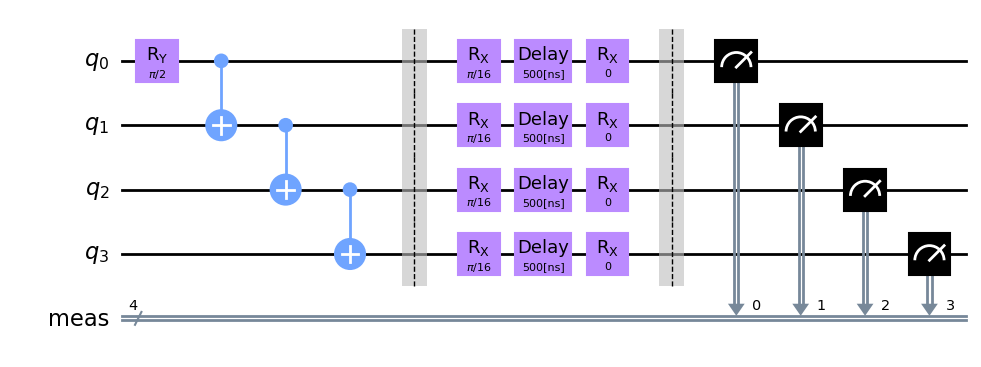

In [11]:
ckts[128][0].draw('mpl')

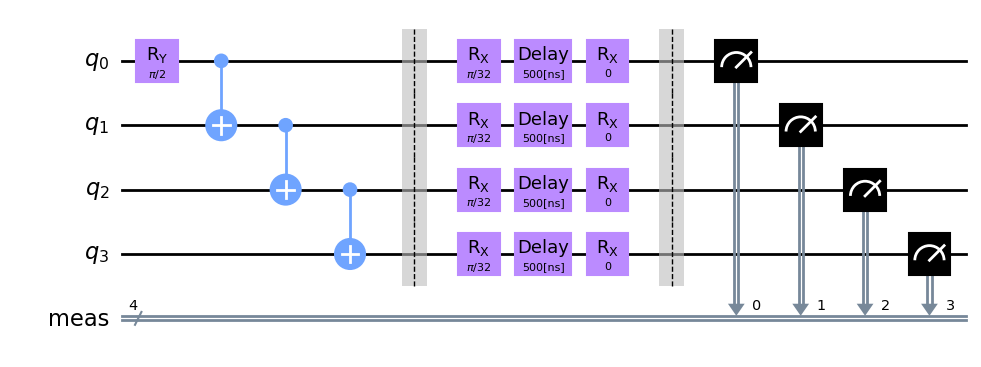

In [12]:
ckts[64][0].draw('mpl')

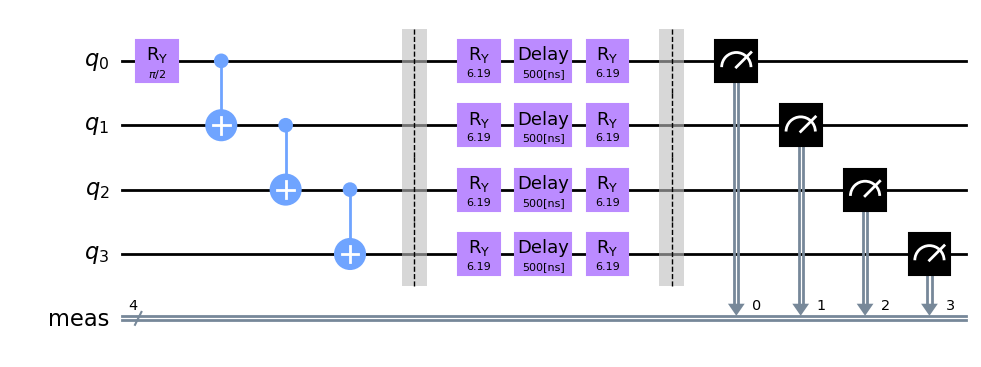

In [13]:
ckts[16383][0].draw('mpl')

In [14]:
def getError(ckt_info):
  return ckt_info['error']

In [15]:
from tqdm import tqdm
min_error = 999999
min_err_info = None
min_ckt = None
theta = []
error = []

for ckt in tqdm(range(len(ckts))):
  qc = ckts[ckt][0]
  counts = backend.run(qc,shots=10000).result().get_counts()
  err = cost(counts)
  err['index'] = ckt
  error.append(err)

error.sort(key=getError)


100%|██████████| 16384/16384 [04:57<00:00, 55.10it/s]


In [23]:
print(error[0])

{'invalid_states_count': 481, 'deviation': 0, 'error': 0.0481, 'index': 7462}
